In [19]:
# All project imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the dataset
df = pd.read_csv("../Raw_data/heart_2020.csv")
# Drop columns that are not important to the dataset
df.drop(columns=["PhysicalHealth", "MentalHealth", "SleepTime"], inplace=True)
# Print the name of each column, as well as the unique values found in each column
for column in df:
    print("%s -> " % column, df[column].unique())

HeartDisease ->  ['No' 'Yes']
BMI ->  [16.6  20.34 26.58 ... 62.42 51.46 46.56]
Smoking ->  ['Yes' 'No']
AlcoholDrinking ->  ['No' 'Yes']
Stroke ->  ['No' 'Yes']
DiffWalking ->  ['No' 'Yes']
Sex ->  ['Female' 'Male']
AgeCategory ->  ['55-59' '80 or older' '65-69' '75-79' '40-44' '70-74' '60-64' '50-54'
 '45-49' '18-24' '35-39' '30-34' '25-29']
Race ->  ['White' 'Black' 'Asian' 'American Indian/Alaskan Native' 'Other'
 'Hispanic']
Diabetic ->  ['Yes' 'No' 'No, borderline diabetes' 'Yes (during pregnancy)']
PhysicalActivity ->  ['Yes' 'No']
GenHealth ->  ['Very good' 'Fair' 'Good' 'Poor' 'Excellent']
Asthma ->  ['Yes' 'No']
KidneyDisease ->  ['No' 'Yes']
SkinCancer ->  ['Yes' 'No']


One-Hot-Encoding Step

In [3]:
# One-hot encode categorical attributes in the dataset

# List of all attribute that we wish to one-hot encode or binary encode
categorical_attributes = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "Sex", "Race", "Diabetic", "PhysicalActivity", "Asthma", "KidneyDisease", "SkinCancer"]
# If an attribute has only two categories, only create one new attribute when encoding it.
# Normally, one-hot encoding would create two new attributes for binary categories.
encoder = OneHotEncoder(drop="if_binary")
# Generate an encoding scheme for the specified columns
encoder.fit(df[categorical_attributes])
# Print the names of all the new attributes created by the one-hot encoder
print(encoder.get_feature_names_out(categorical_attributes))
# Replace the categorical columns in the DataFrame with the new, one-hot encoded columns
encoded_df = pd.DataFrame(encoder.transform(df[categorical_attributes]).toarray(), columns=encoder.get_feature_names_out(categorical_attributes))
df = df.drop(columns=categorical_attributes).join(encoded_df)
print(df.head(1))

['HeartDisease_Yes' 'Smoking_Yes' 'AlcoholDrinking_Yes' 'Stroke_Yes'
 'DiffWalking_Yes' 'Sex_Male' 'Race_American Indian/Alaskan Native'
 'Race_Asian' 'Race_Black' 'Race_Hispanic' 'Race_Other' 'Race_White'
 'Diabetic_No' 'Diabetic_No, borderline diabetes' 'Diabetic_Yes'
 'Diabetic_Yes (during pregnancy)' 'PhysicalActivity_Yes' 'Asthma_Yes'
 'KidneyDisease_Yes' 'SkinCancer_Yes']
    BMI AgeCategory  GenHealth  HeartDisease_Yes  Smoking_Yes  \
0  16.6       55-59  Very good               0.0          1.0   

   AlcoholDrinking_Yes  Stroke_Yes  DiffWalking_Yes  Sex_Male  \
0                  0.0         0.0              0.0       0.0   

   Race_American Indian/Alaskan Native  ...  Race_Other  Race_White  \
0                                  0.0  ...         0.0         1.0   

   Diabetic_No  Diabetic_No, borderline diabetes  Diabetic_Yes  \
0          0.0                               0.0           1.0   

   Diabetic_Yes (during pregnancy)  PhysicalActivity_Yes  Asthma_Yes  \
0        

Ordinal Encoding Step

In [4]:
# Encode categorical attributes that have a logical ordering. Since such an ordering exists,
# we can avoid creating extraneous columns by assigning a number to each category, rather than
# trying to use a one-hot encoding scheme for them.

# There are only two categorical attributes which have a logical ordering
categorical_attributes = ["AgeCategory", "GenHealth"]
# List the possible categories for each attribute in their logical order
age_categories = ["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80 or older"]
health_categories = ["Poor", "Fair", "Good", "Very good", "Excellent"]
# Create the ordinal encoder and generate the encoding scheme for our DataFrame
encoder = OrdinalEncoder(categories=[age_categories, health_categories])
encoder.fit(df[categorical_attributes])
# Replace the categorical columns in the DataFrame with the new, ordinal-encoded columns
encoded_df = pd.DataFrame(encoder.transform(df[categorical_attributes]), columns=["AgeCategory_Ordinal", "GenHealth_Ordinal"])
df = df.drop(columns=categorical_attributes).join(encoded_df)
print(df.head(1))

    BMI  HeartDisease_Yes  Smoking_Yes  AlcoholDrinking_Yes  Stroke_Yes  \
0  16.6               0.0          1.0                  0.0         0.0   

   DiffWalking_Yes  Sex_Male  Race_American Indian/Alaskan Native  Race_Asian  \
0              0.0       0.0                                  0.0         0.0   

   Race_Black  ...  Diabetic_No  Diabetic_No, borderline diabetes  \
0         0.0  ...          0.0                               0.0   

   Diabetic_Yes  Diabetic_Yes (during pregnancy)  PhysicalActivity_Yes  \
0           1.0                              0.0                   1.0   

   Asthma_Yes  KidneyDisease_Yes  SkinCancer_Yes  AgeCategory_Ordinal  \
0         1.0                0.0             1.0                  7.0   

   GenHealth_Ordinal  
0                3.0  

[1 rows x 23 columns]


Standardize BMI column using min-max scaling. Only one column affected.

In [5]:
df[['BMI']] = minmax_scale(df[['BMI']])
print(df.head(1))

        BMI  HeartDisease_Yes  Smoking_Yes  AlcoholDrinking_Yes  Stroke_Yes  \
0  0.055294               0.0          1.0                  0.0         0.0   

   DiffWalking_Yes  Sex_Male  Race_American Indian/Alaskan Native  Race_Asian  \
0              0.0       0.0                                  0.0         0.0   

   Race_Black  ...  Diabetic_No  Diabetic_No, borderline diabetes  \
0         0.0  ...          0.0                               0.0   

   Diabetic_Yes  Diabetic_Yes (during pregnancy)  PhysicalActivity_Yes  \
0           1.0                              0.0                   1.0   

   Asthma_Yes  KidneyDisease_Yes  SkinCancer_Yes  AgeCategory_Ordinal  \
0         1.0                0.0             1.0                  7.0   

   GenHealth_Ordinal  
0                3.0  

[1 rows x 23 columns]


Split the Data

In [6]:
# Separate the data into input (X) and output (y)
X = df.drop(columns="HeartDisease_Yes")
y = df["HeartDisease_Yes"]
# Further split the data into training sets and testing sets with a 90:10 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

## Model 1: K-Nearest Neighbors

In [35]:
# We begin our exploration of simple models by looking at perhaps the most
# straightforward classification technique: k-nearest neighbors. With this
# method, we treat each sample in our training set as a vector in an
# n-dimensional space, where n is the number of attributes in the dataset.
# When predicting the label of a test sample, we simply find the k training
# samples closest in n-dimensional space to said test sample, and let those
# neighbors vote on what the classification should be based on their
# own known labels.

# Since k (the number of closest neighbors to consider) is a hyperparameter
# of our model that can affect performance, we should experiment with different
# values of k to find the best-performing one. To accomplish this, we will perform
# a manual grid search over a few values of k, and we'll keep the model with
# highest f1 score; we value f1 score because we seek to reduce the number of
# false negatives and false positives as much as possible, especially with the 
# medical nature of our project.

# We opt to perform a manual grid search rather than use scikit-learn's
# GridSearchCV simply for the sake of saving on computation time. K-nearest
# neighbors is quite computationally expensive at prediction time (especially
# with a dataset as immense as ours), so the cross-validation that GridSearchCV
# performs when evaluating models would take an impractical amount of time
# to finish running.

# The best-performing model from our grid search will be stored here
tuned_neighbors_model = None
# The predictions from the best-performing model will be stored here
y_pred_neighbors = None
# Keep track of the highest f1 score we've observed thus far
highest_neighbors_score = -1
# Keep track of the f1 scores for all models
f1_scores = []
# Define the values of k that we should test. The default number of neighbors
# is 5, so we'll try that along with a smaller value and a larger value.
k_values = [1, 5, 9]

# Test one model with each value of k
for k in k_values:
    # Create the model and fit it to our training data
    neighbors_model = KNeighborsClassifier(n_neighbors=k)
    neighbors_model.fit(X_train, y_train)
    # Use the model to predict labels for our test set
    y_pred = neighbors_model.predict(X_test)
    # Calculate and save the model's f1 score
    score = f1_score(y_true=y_test, y_pred=y_pred)
    f1_scores.append(score)
    # If this model has the highest f1 score we've seen so far, save both
    # it and its predicted labels
    if score > highest_neighbors_score:
        highest_neighbors_score = score
        tuned_neighbors_model = neighbors_model
        y_pred_neighbors = y_pred

Best hyperparmater (k):  1
Test f1 score: 0.231836
Test precision: 0.232771
Test recall: 0.230909
Test accuracy: 0.868418


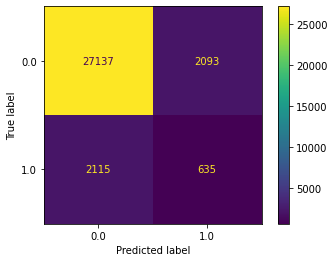

In [49]:
# Print the k value that resulted in the best-performing model
print("Best hyperparmater (k): ", k_values[np.argmax(f1_scores)])
# Print the model's f1 score, precision, recall, and accuracy on the test set
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred_neighbors))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred_neighbors))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred_neighbors))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred_neighbors))
# Plot the confusion matrix for the test predictions
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_neighbors)
plt.show()

## Oversampling Our Dataset

In [7]:
# Before moving forward with more models, we must address one more issue with our
# dataset that might affect certain models' performance: imbalance. As large as
# our dataset is, it might not present an even distribution of the target attribute
# that we wish to predict (i.e., whether or not a person has heart disease). To
# check this distribution, we can print out a count of how many people (samples)
# in our training set have heart disease, and how many don't.
y_train.value_counts()

0.0    263192
1.0     24623
Name: HeartDisease_Yes, dtype: int64

In [8]:
# As seen in the above cell, our data is heavily imbalanced with respect to
# our target attribute; the split is on the order of 10:1. This may pose a
# problem for some of the classification models we wish to try out. In
# particular, any model which seeks to minimize the total classification
# error over all samples may suffer greatly from this data imbalance. Since
# the vast majority of samples do not have heart disease, these types of
# classification models will heavily value the correct classification of
# people who don't have heart disease, and will severely undervalue the
# correct classification of people who do have heart disease.

# Obviously, with our desire to maximize the f1 score of our final
# classification model (and, of course, with our desire to correctly
# warn as many people as possible that they have heart disease), the
# bias in our dataset is far from desirable. As such, we will take
# corrective action and perform some oversampling on our training data.

# In particular, we will use random oversampling to balance out our
# dataset. During the oversampling process, the original training data
# is augmented with extra samples of people with heart disease (which
# are randomly drawn duplicates of already existing training samples).
# The training data is agumented with these extra samples until the number
# of samples with heart disease is equal to the number of samples without.
# This way, we'll have a perfectly even distribution of our target
# attribute when training future models.
over_sampler = RandomOverSampler(random_state=0)
X_train_oversampled, y_train_oversampled = over_sampler.fit_resample(X_train, y_train)
y_train_oversampled.value_counts()

0.0    263192
1.0    263192
Name: HeartDisease_Yes, dtype: int64

## Model 2: Logistic Regression

Test f1 score: 0.174309
Test precision: 0.528545
Test recall: 0.104364
Test accuracy: 0.914978


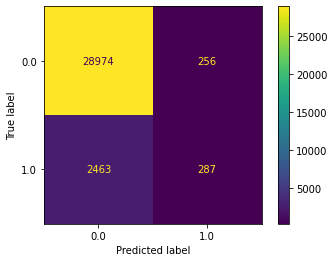

In [50]:
# Next, we'll try a model with a slightly more advanced formulation:
# logistic regression. The predictor works by taking a weighted sum
# (i.e., some linear combination) of a sample's attributes and feeding
# that sum into the sigmoid function. The sample is labeled positive or
# negative based on whether the sigmoid output is above or below some 
# threshold. The weights (for the weighted sum) are optimized such that
# the classification error is minimized over the training set.

# To begin with, we can attempt to train a logistic regression model
# (with mostly default hyperparameters) on our original training set,
# to see what kind of results we can get with our imbalanced data.

# Instantiate a logistic regression model from scikit-learn
logistic_model = LogisticRegression(max_iter=1000)
# Tune the weights of the model using our original training data
logistic_model.fit(X_train, y_train)
# Use the trained model to predict labels for our test set
y_pred = logistic_model.predict(X_test)
# Print out the model's performance statistics on the test set
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred))
# Display the confusion matrix on the test set
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Test f1 score: 0.349919
Test precision: 0.225340
Test recall: 0.782545
Test accuracy: 0.749969


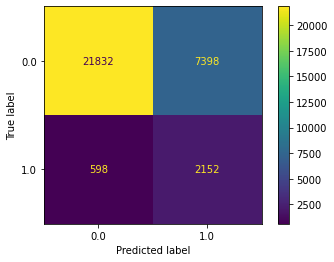

In [51]:
# As seen in the above cell, the logistic regression model trained
# on the original data obtains an f1 score that is lower than that
# of the k-nearest neighbors model. Contributing most to this is
# the recall, which is less than half of k-nearest neighbors. A
# low recall is certainly not desirable for our final model, because
# that would mean that the model produces a lot of false negatives.
# A false negative, for our purposes, means that a person is told
# that they do not have heart disease, when they in fact do have it.

# To try and remedy this low f1 score and particularly low recall,
# we can train another logistic regression model (again, with nearly
# default hyperparameters) on our oversampled training data. This 
# will give the model a larger proportion of samples with heart
# disease to train on, so that it is forced to value the correct
# classification of positive samples more strongly.
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_oversampled, y_train_oversampled)
y_pred = logistic_model.predict(X_test)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [10]:
# As seen above, the results from training on the oversampled data are much
# more favorable than the results from the original data. Although the
# precision went down a bit, the recall skyrocketed and the f1 score doubled.
# Thus, we'll choose to train on the oversampled data for our logistic
# regression model. 

# Next, we'll want to fine-tune our model to squeeze out as much performance
# as we can out of it. For that purpose, we'll once again turn to grid search.
# Since this type of model is less brute-force than k-nearest neighbors
# (and thus, more computationally efficient), we will opt to use scikit-learn's
# GridSearchCV here, so that the candidate models are more rigorously
# evaluated through cross-validation.

# Instantiate a logistic regression model. Due to the large size
# of our dataset, it may take more than the default 100 iterations
# for the logistic model to converge. Thus, we increase the
# maximum number of iterations before termination.
base_logistic_model = LogisticRegression(max_iter=1000)
# Define a hyperparameter space to search through. This will
# allow the model to find the hyperparameter values that yield
# the highest cross-validated score.
logistic_parameters = [
    {
        # Type of regularization
        "penalty": ["l1"], 
        # Algorithm for locating a local minimum
        "solver": ["liblinear", "saga"], 
        # Inverse strength of the regularization term
        "C": [0.1, 1.0, 100.0]
    },
    {
        "penalty": ["l2"], 
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"], 
        "C": [0.1, 1.0, 100.0]
    }
]
# Initialize a grid search object. Make it use f1 score as its performance
# metric when comparing models with different hyperparameters. For our
# purposes, f1 score is a useful metric to maximize because it represents
# the harmonic mean of precision and recall. By maximizing f1 score, then,
# we maximize precision and recall simultaneously. In other words, we 
# minimize the number of false positives and false negatives, while also
# maximizing the number of true positives.
tuned_logistic_model = GridSearchCV(base_logistic_model, param_grid=logistic_parameters, scoring="f1", n_jobs=-1)
# Search the hyperparameter space for the best-performing model on the training data
tuned_logistic_model.fit(X_train_oversampled, y_train_oversampled)

GridSearchCV(estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid=[{'C': [0.1, 1.0, 100.0], 'penalty': ['l1'],
                          'solver': ['liblinear', 'saga']},
                         {'C': [0.1, 1.0, 100.0], 'penalty': ['l2'],
                          'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                     'saga']}],
             scoring='f1')

Best hyperparmaters:  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Best training f1 score:  0.767938352434175
Test f1 score: 0.349996
Test precision: 0.225374
Test recall: 0.782909
Test accuracy: 0.749937


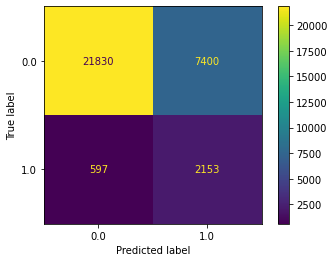

In [11]:
# Print out the set of hyperparameters that resulted in the model with
# highest f1 score, along with that f1 score itself
print("Best hyperparmaters: ", tuned_logistic_model.best_params_)
print("Best training f1 score: ", tuned_logistic_model.best_score_)

# Use the model to predict labels for our test set, and print out the
# performance metrics on that test set
y_pred_logistic = tuned_logistic_model.predict(X_test)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred_logistic))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred_logistic))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred_logistic))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred_logistic))
# Finally, plot the confusion matrix for our test set predictions
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_logistic)
plt.show()

## Model 3: Support Vector Machine (SVM)

Test f1 score: 0.071257
Test precision: 0.615385
Test recall: 0.037818
Test accuracy: 0.915228


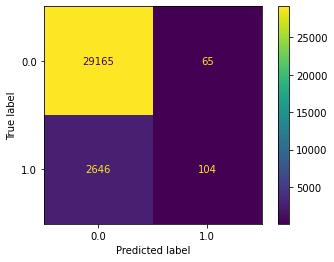

In [10]:
# Our next simple model to try out is a Support Vector Machine, usually
# abbreviated to SVM. This type of model works by finding a hyperplane
# in n-dimensional space which separates our binary data with the largest
# margin. Test samples are then classified based on which side of the
# hyperplane they land on.

# The time complexity for scikit-learn's regular SVC class does not scale
# well with increasingly large amounts of training data. Since our dataset
# has hundreds of thousands of samples, it would take an infeasible amount
# of time to train the regular SVC class. Instead, then, we'll use the
# LinearSVC class, which is better optimized for larger datasets. This
# means that we will not be able to use nonlinear kernels, but the
# training time is much more practical this way.

# As with the logistic regression model, we'll first try to train an 
# SVM model using our original, imbalanced training data. Since SVM
# tries to minimize classification error over the entire training set,
# we should see reduced performance when training on the original data.

svm_model = LinearSVC(max_iter=10000)
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Test f1 score: 0.347819
Test precision: 0.223336
Test recall: 0.785818
Test accuracy: 0.746592


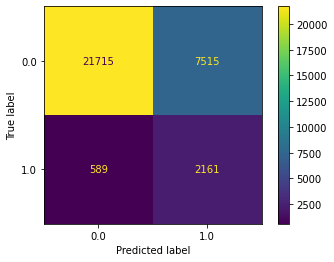

In [11]:
# The results from above give us a baseline to compare against. From
# those results, we can see that training on the original data results
# in an abysmally low f1 score (in fact, it is the lowest f1 score
# we've seen so far). Obviously, we'll need to try something else
# in order to remedy this.

# Now we can train another SVM model, this time using our oversampled
# training data. In theory, training on the augmented data should yield
# better results, given the nature of SVM's loss function. However,
# we'll train this single model to make sure of that.
svm_model = LinearSVC(max_iter=10000)
svm_model.fit(X_train_oversampled, y_train_oversampled)
y_pred = svm_model.predict(X_test)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [9]:
# From the cell above, we can see that training on the oversampled
# data results in markedly better performance when predicting labels
# on the test set. The f1 score is now on par with that of our tuned
# logistic regression model. Given this, we'll choose to continue
# training with the oversampled training data.

# We can now do as we've done with the other models and perform a grid
# search to find the best hyperparameters for our linear SVM model.
base_svm_model = LinearSVC()
svm_parameters = [
    {
        "penalty": ["l1"],
        "loss": ["squared_hinge"],
        "dual": [False],
        "C": [0.1, 1.0, 100.0]
    },
    {
        "penalty": ["l2"],
        "loss": ["squared_hinge"],
        "dual": [False, True],
        "C": [0.1, 1.0, 100.0]
    },
    {
        "penalty": ["l2"],
        "loss": ["hinge"],
        "dual": [True],
        "C": [0.1, 1.0, 100.0]
    }
]
tuned_svm_model = GridSearchCV(base_svm_model, param_grid=svm_parameters, scoring="f1", n_jobs=-1)
tuned_svm_model.fit(X_train_oversampled, y_train_oversampled)

c:\Python39\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(estimator=LinearSVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1.0, 100.0], 'dual': [False],
                          'loss': ['squared_hinge'], 'penalty': ['l1']},
                         {'C': [0.1, 1.0, 100.0], 'dual': [False, True],
                          'loss': ['squared_hinge'], 'penalty': ['l2']},
                         {'C': [0.1, 1.0, 100.0], 'dual': [True],
                          'loss': ['hinge'], 'penalty': ['l2']}],
             scoring='f1')

Best hyperparmaters:  {'C': 0.1, 'dual': True, 'loss': 'hinge', 'penalty': 'l2'}
Best training f1 score:  0.7715733597389903
Test f1 score: 0.344611
Test precision: 0.219880
Test recall: 0.796364
Test accuracy: 0.739525


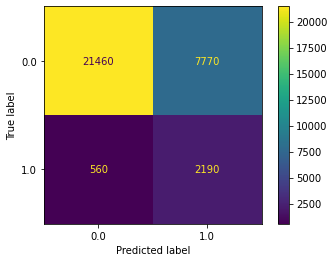

In [10]:
# As with the other models, we now report the best hyperparameters
# and the f1 score that the corresponding model was able to achieve
print("Best hyperparmaters: ", tuned_svm_model.best_params_)
print("Best training f1 score: ", tuned_svm_model.best_score_)

# Finally, we use our tuned SVM to predict test labels, report
# performance statistics on the test set, and plot the confusion
# matrix
y_pred_svm = tuned_svm_model.predict(X_test)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred_svm))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred_svm))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred_svm))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.show()

## Model 4: Naive Bayes Classifier

Test f1 score: 0.303116
Test precision: 0.338876
Test recall: 0.274182
Test accuracy: 0.891588


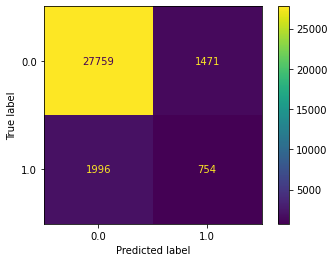

In [11]:
# Our next model to try is a Naive Bayes Classifier. This type of model uses
# "naive" probabilistic reasoning to predict the likelihood of a test sample
# having one label or another.

# Since the vast majority of our attributes are binary, we'll try using a 
# Bernoulli Naive Bayes Classifier, which specifically tries to work with
# binary random variables. 

# This type of classifier ONLY accepts binary attributes, however, so we'll
# have to remove the attributes that we applied ordinal encoding to earlier,
# as those are essentially categorical variables.
X_train_bayes = X_train.drop(columns=["AgeCategory_Ordinal", "GenHealth_Ordinal"])
X_test_bayes = X_test.drop(columns=["AgeCategory_Ordinal", "GenHealth_Ordinal"])

# Since BMI is more of a continuous variable than a categorical variable, we
# may be able to extract some useful information from it for our Bernoulli
# classifier. To convert this continuous variable into a binary variable, we
# can simply encode a BMI value as 1 if it is at or above the average BMI from
# the training set, or encode it as a 0 if it is below that average BMI.
average_bmi = X_train["BMI"].mean()
X_train_bayes["BMI"] = X_train_bayes["BMI"].map(lambda a: (0 if a < average_bmi else 1))
X_test_bayes["BMI"] = X_test_bayes["BMI"].map(lambda a: (0 if a < average_bmi else 1))

# Now we can instantiate a Bernoulli Naive Bayes classifier, fit it to our
# training data, use it to predict labels for our test data, and print the
# performance metrics for that test data.
bayes_model = BernoulliNB(binarize=None)
bayes_model.fit(X_train_bayes, y_train)
y_pred = bayes_model.predict(X_test_bayes)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Test f1 score: 0.337656
Test precision: 0.220575
Test recall: 0.719636
Test accuracy: 0.757223


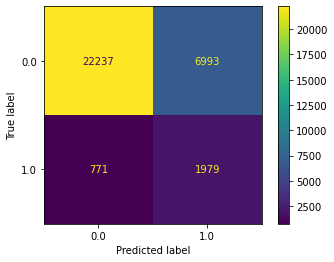

In [12]:
# Although the performance of our Bernoulli Naive Bayes Classifier is
# respectable compared to our other models, we must keep in mind one of
# the main weaknesses of an NB classifier: it performs particularly poorly
# on unbalanced datasets. Unfortunately, as previously established, our 
# dataset is quite unbalanced, with only about 10% of the samples having 
# heart disease. To remedy this, we could try and train an NB classifier
# using our oversampled training data, as we have with the previous two
# types of models. However, scikit-learn actually has another type of
# NB classifier, known as a Complement Naive Bayes Classifier, which is
# designed to improve upon this weakness of traditional NB classifiers.
# As such, we'll try to use this Complement NB classifier on our original
# training data instead.

# In addition to better performance on unbalanced datasets, the Complement
# NB classifier also has the advantage of being tolerant to categorical
# variables, and not just binary variables. Thus, we can add our ordinally-
# encoded attributes back into our datasets. However, we'll still convert
# the "BMI" attribute into a binary variable, since the NB classifier
# still isn't meant to handle continuous variables.
X_train_bayes = X_train.copy()
X_test_bayes = X_test.copy()
X_train_bayes["BMI"] = X_train_bayes["BMI"].map(lambda a: (0 if a < average_bmi else 1))
X_test_bayes["BMI"] = X_test_bayes["BMI"].map(lambda a: (0 if a < average_bmi else 1))

# Now we can fit and test the Complement NB classifier, as we did with the
# Bernoulli classifier.
bayes_model = ComplementNB()
bayes_model.fit(X_train_bayes, y_train)
y_pred = bayes_model.predict(X_test_bayes)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [13]:
# As we can see from the above results, the Complement NB classifier
# has a tremendously larger recall score than the Bernoulli classifier
# (at the expense of accuracy, but alas). We will move forward with
# the Complement classifier, since we value recall very highly.

# We can now perform a small grid search on the Complement NB classifier
# to make sure that we squeeze as much cross-validated performance as
# we can out of it.
base_bayes_model = ComplementNB()
bayes_parameters = {
    "alpha": [0.0, 1.0],
    "norm": [False, True]
}
tuned_bayes_model = GridSearchCV(base_bayes_model, param_grid=bayes_parameters, scoring="recall", n_jobs=-1)
tuned_bayes_model.fit(X_train_bayes, y_train)

c:\Python39\lib\site-packages\sklearn\naive_bayes.py:591: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


GridSearchCV(estimator=ComplementNB(), n_jobs=-1,
             param_grid={'alpha': [0.0, 1.0], 'norm': [False, True]},
             scoring='recall')

Best hyperparmaters:  {'alpha': 0.0, 'norm': False}
Best training f1 score:  0.7195711711414516
Test f1 score: 0.337656
Test precision: 0.220575
Test recall: 0.719636
Test accuracy: 0.757223


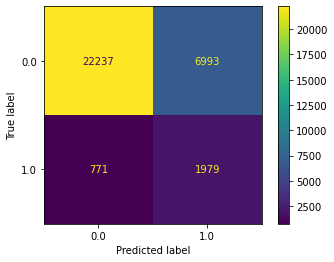

In [14]:
# Print out the best-performing hyperparameters, and the f1 score
# score that they achieved
print("Best hyperparmaters: ", tuned_bayes_model.best_params_)
print("Best training f1 score: ", tuned_bayes_model.best_score_)

# Predict test labels using our tuned Complement NB classifier
y_pred_bayes = tuned_bayes_model.predict(X_test_bayes)
# Print out performance statistics on the test set
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred_bayes))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred_bayes))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred_bayes))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred_bayes))
# Finally, show the confusion matrix for the test predictions
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_bayes)
plt.show()

## Model 5: Decision Tree

Test f1 score: 0.246580
Test precision: 0.254349
Test recall: 0.239273
Test accuracy: 0.874265


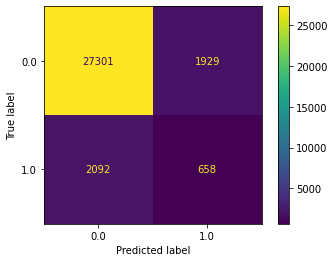

In [17]:
# The final simple model we'll use to try and classify our data is a decision
# tree. This type of model works by taking a divide-and-conquer approach to
# separating and classifying samples. It builds a tree where every node
# represents a subset of the training samples. At each of these nodes, one
# of the dataset attributes is used to partition the current subset of 
# samples into two or more smaller subsets. The attribute used to partition
# the data at each node of the decision tree is chosen based on how effectively
# the attribute will split the current subset of samples. The effectiveness
# of a split is usually quantified by information gain or entropy loss.
# The tree continues splitting the training data until it reaches a point of
# satisfaction (usually determined by hyperparameters), and it then labels
# each leaf node with one of the target attribute categories. When a test
# sapmle is fed to the classifier, the sample descends down the tree based
# on its attribute values, and eventually lands in a leaf node. The label
# of that leaf node determines the predicted label of the test sample.

# To get a sense of what a decision tree is capable of, we can train one
# using the default hyperparameters on our original training set.
tree_model = DecisionTreeClassifier(random_state=0)
tree_model.fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

Test f1 score: 0.246353
Test precision: 0.222222
Test recall: 0.276364
Test accuracy: 0.854597


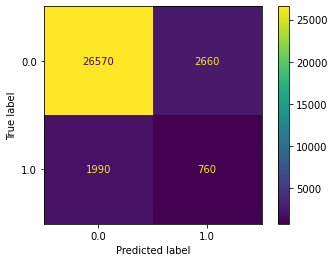

In [20]:
# Although the results from above are reasonable, we can try to take this type of model
# further by experimenting with the use of a random forest classifier. This type of
# classifier works by actually constructing multiple decision trees. Each tree is
# constructed using some randomly chosen subset of attributes, and a test sample is
# evaluated using all of the decision trees in the forest. Each tree provides one
# vote as to what the label of the test sample should be, and the majority vote
# is used as the final predicted label.

# Because multiple varied trees are constructed and used for evaluation, this type
# of classifier should be good for avoiding overfitting. It also has many more
# hyperparameters to tune than a single decision tree, so we'll try to use this
# model for all of its increased flexibility.

# The trees can optionally be constructed using a random subset of the training
# data. Because of this feature, we'll try training the random forest using our
# oversampled training data, so that each tree is likely to get a somewhat even
# distribution of samples with respect to the target attribute.

forest_model = RandomForestClassifier(random_state=0, n_jobs=-1)
forest_model.fit(X_train_oversampled, y_train_oversampled)
y_pred = forest_model.predict(X_test)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

In [31]:
# Although the performance of the random forest is pretty similar to that
# of the single decision tree, we will still move forward with the random
# forest, because (1) it has increased flexibility, as mentioned before,
# and (2) it resulted in a higher amount of true positives, which is
# perhaps the single most important quantity in the confusion matrix.

# As with our other models, we now perform a grid search to try and find
# the hyperparameters that result in the best-performing random forest
# classifier.
base_forest_model = RandomForestClassifier(random_state=0, n_jobs=-1)
forest_parameters = {
    "n_estimators": [10, 100, 1000],
    "min_samples_split": [2, 0.1, 0.001],
    "max_samples": [None, 0.5, 0.1]
}
tuned_forest_model = GridSearchCV(base_forest_model, param_grid=forest_parameters, scoring="f1", n_jobs=-1)
tuned_forest_model.fit(X_train_oversampled, y_train_oversampled)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             n_jobs=-1,
             param_grid={'max_samples': [None, 0.5, 0.1],
                         'min_samples_split': [2, 0.1, 0.001],
                         'n_estimators': [10, 100, 1000]},
             scoring='f1')

Best hyperparmaters:  {'max_samples': None, 'min_samples_split': 2, 'n_estimators': 100}
Best training f1 score:  0.9488307049805389
Test f1 score: 0.246353
Test precision: 0.222222
Test recall: 0.276364
Test accuracy: 0.854597


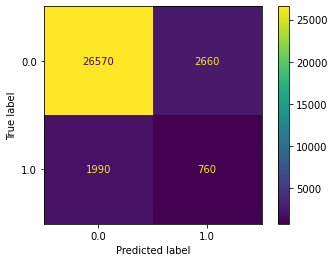

In [48]:
# Now we can report the best hyperparameters and the f1 score that 
# the corresponding model was able to achieve
print("Best hyperparmaters: ", tuned_forest_model.best_params_)
print("Best training f1 score: ", tuned_forest_model.best_score_)

# Finally, we use our tuned model to predict test labels, report
# performance statistics on the test set, and plot the confusion
# matrix
y_pred_forest = tuned_forest_model.predict(X_test)
print("Test f1 score: %f" % f1_score(y_true=y_test, y_pred=y_pred_forest))
print("Test precision: %f" % precision_score(y_true=y_test, y_pred=y_pred_forest))
print("Test recall: %f" % recall_score(y_true=y_test, y_pred=y_pred_forest))
print("Test accuracy: %f" % accuracy_score(y_true=y_test, y_pred=y_pred_forest))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_forest)
plt.show()